# Exercise 7: TSP

In [272]:
import numpy as np
import math
import matplotlib.pyplot as plt

## 1.
Implement simulated annealing for the travelling salesman. As proposal, permute two random stations on the route. As
cooling scheme, you can use e.g. $T_k = 1/\sqrt{1+k}$ or $T_k = -\log({k+1})$, feel free to experiment with different
choices. The route must end where it started. Initialise with a
random permutation of stations.

(a) Have input be positions in the plane of the n stations. Let the cost of going $i \rightarrow j$ be the Euclidian distance
between station i and j. Plot the resulting route in the plane. Debug with stations on a circle.

In [316]:
## a) ##

def calculate_cost(path, stations):
    return np.sum(np.sqrt(np.sum(np.diff(stations[path], axis=0)**2, axis=1)))

def create_stations(n):
    r = 10
    thetas = np.linspace(0, 2 * np.pi, n, endpoint=False)
    stations = [(r * np.cos(theta), r * np.sin(theta)) for theta in thetas]
    return np.array(stations)

def new_path(n_stations):
    # Generate a random permutation of stations, excluding the starting station 1
    path = np.random.permutation(n_stations - 1) + 1
    path = np.insert(path, 0, 0)
    path = np.append(path, 0) # Add station 1 to get a feasible solution
    return path

def swap_stations(path):
    neighbor = path.copy()
    i, j = np.random.choice(range(1, len(path) - 1), 2, replace=False)
    neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
    return neighbor

Initial path (station indices) is [1 2 4 5 6 3 1] with cost 114.68892546624792


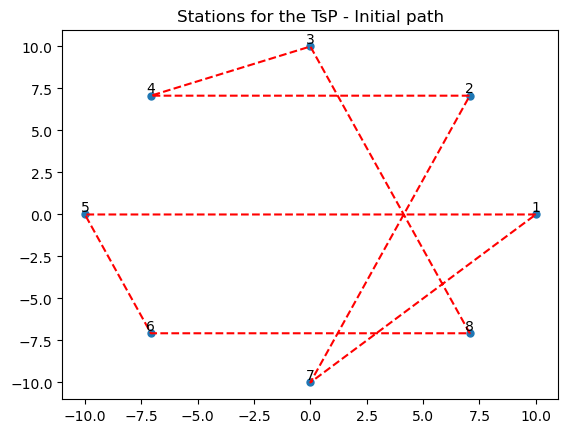

In [318]:
## a) ##

# Number of stations
n_stations = 8

stations = create_stations(n_stations)
initial_path = new_path(n_stations)
path_coordinates = stations[initial_path]
cost = calculate_cost(initial_path, stations)

print(f"Initial path (station indices) is {path + 1} with cost {cost}")

# Plot the stations
plt.plot(stations[:, 0], stations[:, 1], 'o', markersize=5)
plt.plot(path_coordinates[:, 0], path_coordinates[:, 1], 'r--', label='Initial Path')
for i, (x, y) in enumerate(stations):
    plt.text(x, y, f'{i+1}', fontsize=10, ha='center', va='bottom')
plt.title('Stations for the TsP - Initial path')
plt.show()


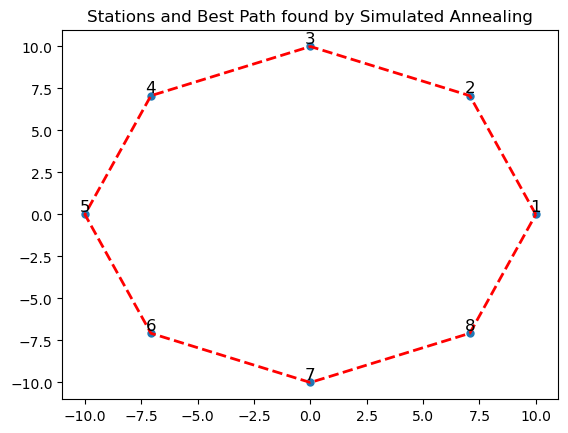

Best path found (station indices): [1 2 3 4 5 6 7 8 1]
Best cost found: 61.22934917841437


In [320]:
## a) ##

# Simulated annealing algorithm
def simulated_annealing(stations, initial_path, iterations=10000):
    current_path = initial_path.copy()
    current_cost = calculate_cost(current_path, stations)
    best_path = current_path.copy()
    best_cost = current_cost

    for k in range(1, iterations + 1):
        T = np.sqrt(1 + k)
        proposed_path = swap_stations(current_path)
        proposed_cost = calculate_cost(proposed_path, stations)

        if np.random.rand() < np.exp(- (proposed_cost - current_cost) / T):
            current_path = proposed_path
            current_cost = proposed_cost

            if current_cost < best_cost:
                best_path = current_path
                best_cost = current_cost

    return best_path, best_cost

# Run simulated annealing
best_path, best_cost = simulated_annealing(stations, initial_path, iterations=10000)

# Plot stations and best path found
plt.plot(stations[:, 0], stations[:, 1], 'o', markersize=5)
plt.plot(stations[best_path, 0], stations[best_path, 1], 'r--', linewidth=2, label='Best Path')
for i, (x, y) in enumerate(stations):
    plt.text(x, y, f'{i+1}', fontsize=12, ha='center', va='bottom')
plt.title('Stations and Best Path found by Simulated Annealing')
plt.show()

# Print results
print(f"Best path found (station indices): {best_path + 1}")  # Adding 1 to match the station labels (1-indexed)
print(f"Best cost found: {best_cost}")

(b) Then modify your progamme to work with costs directly and apply it to the cost matrix from the course homepage.

In [322]:
# Given cost matrix
raw_cost = [0,225,110,8,257,22,83,231,277,243,94,30,4,265,274,250,87,83,271,86,
         255,0,265,248,103,280,236,91,3,87,274,265,236,8,24,95,247,259,28,259,
         87,236,0,95,248,110,25,274,250,271,9,244,83,250,248,280,29,26,239,7,
         8,280,83,0,236,28,91,239,280,259,103,23,6,280,244,259,95,87,230,84,
         268,87,239,271,0,244,275,9,84,25,244,239,275,83,110,24,274,280,84,274,
         21,265,99,29,259,0,99,230,265,271,87,5,22,239,236,250,87,95,271,91,
         95,236,28,91,247,93,0,247,259,244,27,91,87,268,275,280,7,8,240,27,
         280,83,250,261,4,239,230,0,103,24,239,261,271,95,87,21,274,255,110,280,
         247,9,280,274,84,255,259,99,0,87,255,274,280,3,27,83,259,244,28,274,
         230,103,268,275,23,244,264,28,83,0,268,275,261,91,95,8,277,261,84,247,
         87,239,9,103,261,110,29,255,239,261,0,259,84,239,261,242,24,25,242,5,
         30,255,95,30,247,4,87,274,242,255,99,0,24,280,274,259,91,83,247,91,
         8,261,83,6,255,29,103,261,247,242,110,29,0,261,244,230,87,84,280,100,
         242,8,259,280,99,242,244,99,3,84,280,236,259,0,27,95,274,261,24,268,
         274,22,250,236,83,261,247,103,22,91,250,236,261,25,0,103,255,261,5,247,
         244,91,261,255,28,236,261,29,103,9,242,261,244,87,110,0,242,236,95,259,
         84,236,27,99,230,83,7,259,230,230,22,87,93,250,255,247,0,9,259,24,
         91,242,28,87,250,110,6,271,271,255,27,103,84,250,271,244,5,0,271,29,
         261,24,250,271,84,255,261,87,28,110,250,248,248,22,3,103,271,248,0,236,
         103,271,8,91,255,91,21,271,236,271,7,250,83,247,250,271,22,27,248,0]

cost = np.reshape(raw_cost, (20, 20))

# Function to calculate the cost of a path using the given cost matrix
def calculate_cost(path, cost_matrix):
    total_cost = 0
    for i in range(len(path) - 1):
        total_cost += cost_matrix[path[i], path[i+1]]
    return total_cost

In [336]:
# Simulated annealing algorithm
def simulated_annealing(cost_matrix, initial_path, iterations=10_000):
    current_path = initial_path.copy()
    current_cost = calculate_cost(current_path, cost_matrix)
    best_path = current_path.copy()
    best_cost = current_cost

    for k in range(1, iterations + 1):
        T = np.sqrt(1 + k)
        proposed_path = swap_stations(current_path)
        proposed_cost = calculate_cost(proposed_path, cost_matrix)

        if np.random.rand() < np.exp(- (proposed_cost - current_cost) / T):
            current_path = proposed_path
            current_cost = proposed_cost

            if current_cost < best_cost:
                best_path = current_path
                best_cost = current_cost

    return best_path, best_cost

# Number of stations
n_stations = len(cost)

# Initial path (random permutation starting and ending at station 1)
initial_path = new_path(n_stations)
inital_cost = calculate_cost(initial_path, cost)

# Run simulated annealing
best_path, best_cost = simulated_annealing(cost, initial_path, 10_000)

# Print results
print(f"Initial path found (station indices): {initial_path + 1}")  
print(f"Initial cost found: {inital_cost}\n")

print(f"Best path found (station indices): {best_path + 1}") 
print(f"Best cost found: {best_cost}")

Initial path found (station indices): [ 1  7  5 14 17 12  4 13 18  3 20 11  8 15 16 19  9  2  6 10  1]
Initial cost found: 2294

Best path found (station indices): [ 1 18  7 11  3 20 17  9 19 15  2 14  5  8 16 10  6  4 12 13  1]
Best cost found: 911
